In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


from matplotlib import pyplot as plt
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
data = fetch_california_housing(as_frame=True)

In [2]:
# Методы сравнения результатов

class FitScore:
    '''Repetitive fitting and table printing.'''
    header_str = '''|model|RMSE|R2|\n|--|--|--|'''
    def __init__(self):
        self.scores = ''
    def run(self,X,y,model_desc):
        if model_desc in self.scores: # пропускаем запуски того, что уже мерили
            pass
        else:
            model = LinearRegression()
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            self.scores += '''\n|%s| %.05f | %.05f |''' % (model_desc, mean_squared_error(y_pred,y_test), r2_score(y_pred, y_test))
    def pr(self):
        printmd(self.header_str + self.scores)
fs = FitScore()

def get_score(X,y, random_seed=42, model=None):
  if model is None:
    model = LinearRegression()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed )  
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

In [3]:
# единственное мое действенное улучшение из задания 5 перенес сюда
# data['rm_div_lstat'] = data['RM'] / data['LSTAT']
# X = data[[col for col in data.columns if col not in ['MEDV']]]
# y = data[['MEDV']]
# get_score(X, y)

Проверяем на пропуски - их нет.  
Строим pairplot - изучим корреляции и заодно выберем переменную для нормализации.  


In [4]:
data.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


<AxesSubplot:>

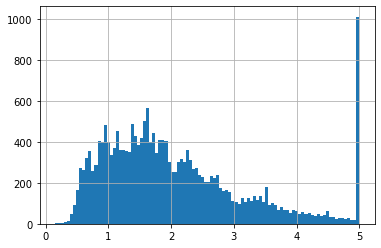

In [5]:
# Целевая переменная - не класс. Сделаем ее классом. Посмотрим, на какие группы разбить MEDV.\
data.target.hist(bins=100)

In [6]:
df = pd.concat([data.data, data.target], axis = 1)
# sns.pairplot(df) # закомментил, чтобы каждый раз не строить - долго
# результат сохранен в pairplot.png рядом с проектом

Нормализовать можно Population и MedInc

<AxesSubplot:>

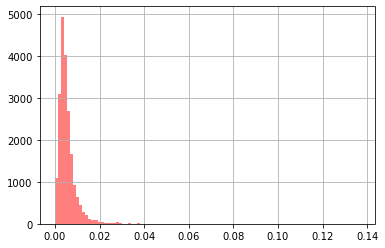

In [7]:
from sklearn.preprocessing import normalize
df['PopNorm'] = normalize(df.Population.values.reshape(-1,1),axis=0)


df.PopNorm.hist(bins=100, fc=(1, 0, 0, 0.5))

Разделим выборку, обучим линейную модель.

In [8]:
model = LinearRegression()
df_X = df[[c for c in df.columns if c != 'MedHouseVal']]
X_train, X_test, y_train, y_test = train_test_split(df_X, df.MedHouseVal, test_size=0.2, random_state=42 )  
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5757877060324511

Повторяем разбиение, как написано в задании и строим дерево

In [9]:
from sklearn.tree import DecisionTreeRegressor
X_train, X_test, y_train, y_test = train_test_split(df_X, df.MedHouseVal, test_size=0.2, random_state=42 )  
tree = DecisionTreeRegressor(max_depth=None, random_state=42)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)
# cross_val_score(regressor, X, y, cv=10)

0.6196604798489249

In [10]:
tree_reg = DecisionTreeRegressor(max_depth=10,
 min_samples_split =100, 
 random_state=42)
tree_reg.fit(X_train, y_train)
tree_reg.score(X_test, y_test)

0.7017713315949505

Небольшая глубина дерева и достаточно крупные листья дали заметную оптимизацию.  
Причем изменение этих параметров в обе стороны дает результат хуже, например, такой:

In [11]:
tree_reg = DecisionTreeRegressor(max_depth=100,
 min_samples_split =10, 
 random_state=42)
tree_reg.fit(X_train, y_train)
tree_reg.score(X_test, y_test)

0.6572137080695167

Визуализация

In [12]:
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal', 'PopNorm'],
      dtype='object')

In [13]:
# Еще раз выполним не очень глубокое дерево для удобства визуализации
tree_reg = DecisionTreeRegressor(max_depth=10,
 min_samples_split =100, 
 random_state=42)
tree_reg.fit(X_train, y_train)
tree_reg.score(X_test, y_test)

0.7017713315949505

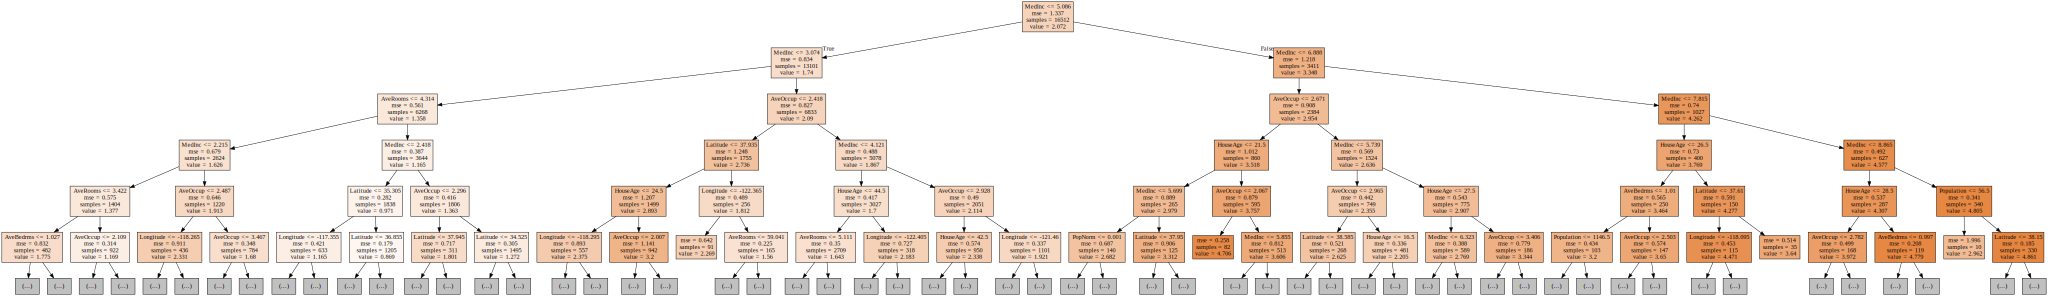

In [20]:
from sklearn import tree
import graphviz
# text_representation = tree.export_text(tree_reg)
# print(text_representation)
dot_data = tree.export_graphviz(tree_reg, out_file=None, 
                                feature_names=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'PopNorm'],  
                                filled=True, max_depth=5)
graphviz.Source(dot_data, format="png") 

# Деревья лежат рядом в папке - 10depth_tree.pdf и 100depth_tree.pdf

In [19]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(tree_reg, X_test, y_test,
                target_name="MedHouseVal",
                feature_names=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'PopNorm'])
# viz
# не нашел в этом методе способа ограничить размер генерируемого файла. max_X_features_LR и max_X_features_TD не меняют вывод.

C:\Users\Sergei\anaconda3\envs\uoit\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Sergei\anaconda3\envs\uoit\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
viz.save("decision_tree.svg")

Выводы.  
Сравнение подходов:  
Линейная регрессия (без обработки данных) хуже, чем дерево.  
Дерево слишком ветвистое - сложно охватить все.  


Оптимизация параметров дерева:  
довольно стабильный результат - должны хорошо оптимизироваться перебором по сетке.  
логика оптимизации неочевидна - наверное плохо оптимизируются алгоритмически.  